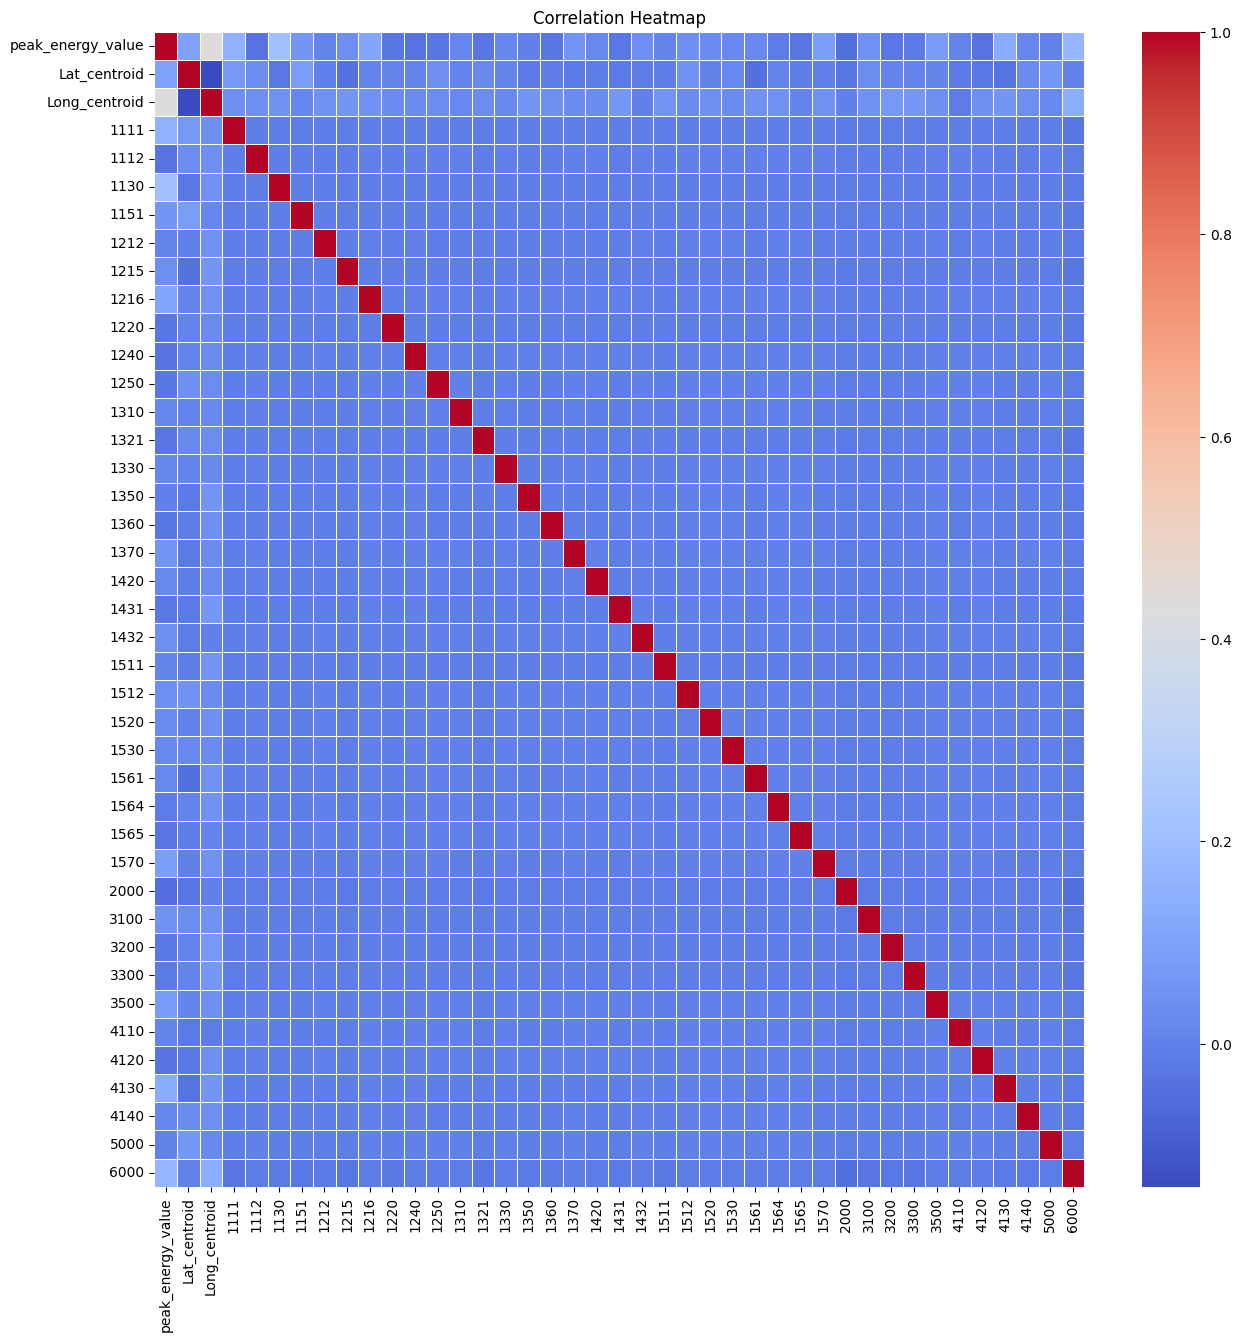

Best XGBoost Parameters: {'subsample': 0.8289473684210527, 'n_estimators': 136, 'max_depth': 6, 'learning_rate': 0.05131578947368421, 'gamma': 0.33842105263157896, 'colsample_bytree': 1.0}
Best XGBoost Score: 0.35236293588835166


KeyboardInterrupt: 

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
import fiona
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load data file
df = pd.read_csv('comed_201910.csv')

# Filter out only residential accounts
df_residential = df[df['service_name'].str.contains('residential', case=False, na=False)]

# Filter for one day, ex. 2019-10-01
desired_date = '2019-10-01'
df_residential = df_residential[df_residential['date_time'].str.contains(desired_date)]

# Convert the time from HH:MM to seconds past since the beginning of the day
df_residential['date_time'] = pd.to_datetime(df_residential['date_time'])
df_residential['seconds_past'] = df_residential['date_time'].dt.hour * 3600 + df_residential['date_time'].dt.minute * 60

# Aggregate data to find time of maximum energy consumption for each zip code
df_grouped = df_residential.groupby('zip5')['energy'].idxmax()
peak_times = df_residential.loc[df_grouped, ['zip5', 'energy', 'seconds_past']]
peak_times.columns = ['zip_code', 'peak_energy_value', 'peak_energy_time']

# Make sure zip_code is integer and other columns are the appropriate type
peak_times['zip_code'] = peak_times['zip_code'].astype(int)
peak_times['peak_energy_value'] = peak_times['peak_energy_value'].astype(float)
peak_times['peak_energy_time'] = peak_times['peak_energy_time'].astype(int)

# Load the geojson file
gdf = gpd.read_file('Chicago_ZC.geojson')

# Convert the 'GEOID20' column to integer for join operation
gdf['GEOID20'] = gdf['GEOID20'].astype(int)

# Merge the peak_times DataFrame with the gdf GeoDataFrame based on 'zip_code'
gdf = gdf.merge(peak_times, left_on='GEOID20', right_on='zip_code', how='left')

# Fill missing values after merge (if any)
gdf.fillna({"zip_code": -1, "peak_energy_value": 0, "peak_energy_time": 0}, inplace=True)

# Convert the geometries to a projected CRS for accurate centroid computation
gdf_projected = gdf.to_crs('EPSG:3857')

# Calculate the centroid of each polygon in projected CRS
gdf_projected['centroid'] = gdf_projected['geometry'].centroid

# Convert the centroid to latitude and longitude coordinates
# Create a new GeoSeries with correct CRS
centroid_geo = gpd.GeoSeries(gdf_projected['centroid'], crs='EPSG:3857')

# Convert this GeoSeries back to geographic CRS for lat/long coordinates
centroid_geo = centroid_geo.to_crs('EPSG:4326')  # Using WGS84 system

# Assign the correctly converted centroid back to original dataframe
gdf['centroid'] = centroid_geo
gdf['Lat_centroid'] = gdf['centroid'].y
gdf['Long_centroid'] = gdf['centroid'].x

# Set the CRS for 'centroid' to be 'EPSG:4326' and replace 'geometry' with 'centroid'
gdf.set_geometry('centroid', inplace=True)
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)  # WGS84 system

# Reset the index
gdf.reset_index(drop=True, inplace=True)

# Load the land use file into a GeoDataFrame
gdb_folder = 'Landuse2018_CMAP_v1.gdb'
layer = 'Landuse2018_Dissolved_v1'

with fiona.Env():
    with fiona.open(gdb_folder, layer=layer) as src:
        crs = src.crs
        records = [{'geometry': f['geometry'], 'LANDUSE': str(f['properties']['LANDUSE'])}
                   for f in src if f is not None and 'geometry' in f]

df = pd.DataFrame.from_records(records)
land_use = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)

# Reproject land_use to a projected CRS using meters as units
land_use = land_use.to_crs('EPSG:3857')

# Ensure main geodataframe is in the same CRS
gdf = gdf.to_crs('EPSG:3857')

# Calculate the area of each polygon in square meters
land_use['area'] = land_use.geometry.area

# Perform spatial join with 'intersects'
land_use_contains_zip = gpd.sjoin(land_use, gdf, how='right', predicate='intersects')

# Aggregate by 'GEOID20' and 'LANDUSE', then reset index
land_use_summary = land_use_contains_zip.groupby(['GEOID20', 'LANDUSE'])['area'].sum().reset_index()

# Pivot the data so that each 'LANDUSE' value becomes a column
land_use_summary_pivot = land_use_summary.pivot(index='GEOID20', columns='LANDUSE', values='area').reset_index()

# Merge the pivot table back to the original geodataframe 'gdf'
gdf_with_landuse = gdf.merge(land_use_summary_pivot, on='GEOID20', how='left')

# Fill NaN values with 0
gdf_with_landuse.fillna(0, inplace=True)

# Land use types are included as features
feature_cols = ['peak_energy_value', 'Lat_centroid', 'Long_centroid'] + land_use_summary_pivot.columns.tolist()[1:]

# Calculate the correlation matrix
corr_matrix = gdf_with_landuse[feature_cols].corr()

# Generate the heatmap
plt.figure(figsize=(15, 15))  # increased figure size
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Split the data into X and Y variables
X = gdf_with_landuse[feature_cols]
Y = gdf_with_landuse['peak_energy_time']

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# *** THIS CODE USES RANDOMIZED SEARCH AND IS LESS COMPUTATIONALLY EXPENSIVE THAN GRID SEARCH *** 

# Refining hyperparameters for XGBoost
xgb_param_grid = {
    'n_estimators': list(range(135, 145)),  # Focusing more on 140
    'max_depth': [6],  # Optimal value from the last search
    'learning_rate': np.linspace(0.045, 0.055, 20),  # Focusing more around 0.049
    'gamma': np.linspace(0.33, 0.37, 20),  # Focusing more around 0.35
    'colsample_bytree': [1.0],  # Optimal value from the last search
    'subsample': np.linspace(0.80, 0.85, 20)  # Focusing more around 0.82
}

xgb_model = xgb.XGBRegressor()

xgb_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid, n_iter=100, cv=5, random_state=42)
xgb_search.fit(X_train, Y_train)

print("Best XGBoost Parameters:", xgb_search.best_params_)
print("Best XGBoost Score:", xgb_search.best_score_)

# Refining hyperparameters for RandomForest
rf_param_grid = {
    'n_estimators': list(range(230, 250)),  # Expanded the range
    'max_depth': list(range(20, 25)),  # Expanded the range
    'min_samples_split': [7, 8, 9],  # Added more options
    'min_samples_leaf': [1, 2],  # Added more options
    'bootstrap': [True, False]  # Added more options
}

rf_model = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, n_iter=100, cv=5, random_state=42)
rf_search.fit(X_train, Y_train)

print("Best RandomForest Parameters:", rf_search.best_params_)
print("Best RandomForest Score:", rf_search.best_score_)

# Fit the models with the best parameters
xgb_best = xgb.XGBRegressor(**xgb_search.best_params_)
xgb_best.fit(X_train, Y_train)

rf_best = RandomForestRegressor(**rf_search.best_params_)
rf_best.fit(X_train, Y_train)

# Feature importance for XGBoost
xgb_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_best.feature_importances_}).sort_values(by='Importance', ascending=False)
print(xgb_importance)

# Feature importance for RandomForest
rf_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_best.feature_importances_}).sort_values(by='Importance', ascending=False)
print(rf_importance)

# Plotting the feature importances for XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance)
plt.title('XGBoost Feature Importance')
plt.show()

# Plotting the feature importances for RandomForest
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance)
plt.title('RandomForest Feature Importance')
plt.show()